# Remembered Object Position Task - Part 1 - Preprocessing & Figures

## Import & Preprocessing

In [1]:
%matplotlib inline

import os
import copy 
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import linregress

from palettable.colorbrewer.qualitative import Set1_9, Set2_8, Paired_12
from palettable.colorbrewer.sequential import YlOrRd_6_r

from helpers import confidence_ellipse

from PIL import Image
plt.style.use('seaborn-v0_8-whitegrid')


In [2]:
# Scene images for plotting
scene_imgs = {'K01': '../images/kitchen_topdown.png',
              'O02': '../images/office_topdown.png'}
SCENE_SCALE = (2.5, 2.5)

# Condition labels
CONDS = ['object', 'cube', 'fixed', 'laser'] 
COND_MARKERS = ['o', 's', 'D', 'p']
COND_LABELS = ['Object', 'Cube', 'Fixed', 'Laser']

# Color sets
PPID_COLORS = Paired_12.mpl_colors + Set1_9.mpl_colors
#COND_COLORS = [Paired_12.mpl_colors[1], Paired_12.mpl_colors[0], Paired_12.mpl_colors[3],  Paired_12.mpl_colors[2]]
COND_COLORS = [Paired_12.mpl_colors[1], Paired_12.mpl_colors[7], Paired_12.mpl_colors[3],  Paired_12.mpl_colors[5]]
SESS_COLORS = YlOrRd_6_r.mpl_colors #Set2_8.mpl_colors[0:4]

# Human readable labels for the objects
OBJECT_LABELS = {'K01_L05': 'Plant', 'K01_L25': 'Painting', 'K01_L16': 'Flowers', 'K01_L09': 'Plate', 'K01_L04': 'Breadbasket', 
                 'K01_L07': 'Espresso Machine', 'K01_L15': 'Water Bottle', 'K01_L13': 'Cutting Board', 'K01_L12': 'Banana', 'K01_L19': 'Kettle',
                 'O02_L26': 'Footstool', 'O02_L23': 'Globe', 'O02_L01': 'Sushi', 'O02_L09': 'Flowers', 'O02_L11': 'Cookies',
                 'O02_L03': 'Printer', 'O02_L18': 'Helicopter', 'O02_L15': 'Clock', 'O02_L05': 'Telephone', 'O02_L06': 'Lamp'}

# File name templates
FILE_GAZE = 'trackers/Eye_gaze_T{:03d}.csv'
FILE_MOVE = 'trackers/VR_move_T{:03d}.csv'

# New label for "stick" condition
STICK_LABEL = 'fixed'


In [3]:
# Raw data folder
folder_data = ['../data/kitchen_laser', '../data/kitchen_object', '../data/kitchen_cube', '../data/kitchen_fixed',
               '../data/office_laser', '../data/office_object', '../data/office_cube', '../data/office_fixed']

# Valid participants and session numbers
SUBS = ['6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
SESS = [1, 2, 3, 4]

folder_out = '../data' # Pickle files and datasets
folder_results = '../results' # Statistics
folder_fig = '../figures' # Figures


### Behavioral Data

In [4]:
def import_data(folder_data, folder_out, subjects, sessions, verbose=False, read_pickle=True):
    """ Import behavioral and movement data """

    pkl_file = os.path.join(folder_out, 'placement_data_raw.pkl')
    csv_file = os.path.join(folder_out, 'placement_trials_raw.csv')

    # Check if preprocessed data exists and return that
    if read_pickle and os.path.isfile(pkl_file) and os.path.isfile(csv_file):
        print('Reading data from pickle, set read_pickle=False to re-import!')
        with open(pkl_file, 'rb') as pf:
            d = pickle.load(pf)
        trials = pd.read_table(csv_file, sep='\t', index_col=False)
        return (trials, d)

    # d[subject][condition][('trials', 'gaze')]
    d = {}
    trials = None
    
    print('Importing and preprocessing data...')
    for folder in folder_data:
        for sub in subjects:
            if sub not in d.keys(): 
                d[sub] = {}
            
            for sess in sessions:
                if verbose:
                    print('sub {:s}, session {:d}'.format(sub, sess))

                p = os.path.join(folder, str(sub), 'S{:03d}'.format(sess))
                
                # TRIAL DATA
                data = None
                try:
                    data = pd.read_csv(os.path.join(p, 'trial_results.csv'), sep=',', index_col=False)
                    Ntrials = data.shape[0]
                    data.loc[:, 'ppid'] = data.ppid.astype(str)

                    # Add extra condition data
                    cond = data.response_mode.values[0]
                    
                    # Re-name the stick condition
                    if cond == 'stick':
                        cond = STICK_LABEL
                        data.loc[data.response_mode == 'stick', 'response_mode'] = STICK_LABEL
                        
                    # Filter the "painting" object due to wrong local origin
                    nopainting = (data.target != 'K01_L25')
                    idx_nopainting = nopainting.index.values # integer indexes of valid trials
                    data = data.loc[nopainting.values, :]
                    
                    if cond not in d[sub].keys():
                        d[sub][cond] = {}
                    data.loc[:, 'trial_valid'] = 1
                    data.loc[:, 'invalid_reason'] = 'valid'                    

                    for trial in range(1, Ntrials+1):
                        
                        # Skip if this trial is not in the filtered index list
                        trial_idx = trial - 1
                        if trial_idx in idx_nopainting: 

                            # GAZE DATA
                            gf = FILE_GAZE.format(trial)
                            gdata = pd.read_csv(os.path.join(p, gf), sep=',', index_col=False)
                            gdata.loc[:, 'trial'] = trial

                            # Set missing data (-99999 or -1.0) to NaN
                            gdata.loc[gdata.gaze_x == -99999.0, 'gaze_x'] = np.nan
                            gdata.loc[gdata.gaze_y == -99999.0, 'gaze_y'] = np.nan
                            gdata.loc[gdata.gaze_z == -99999.0, 'gaze_z'] = np.nan
                            gdata.loc[gdata.pupil_l == -1, 'pupil_l'] = np.nan
                            gdata.loc[gdata.pupil_r == -1, 'pupil_r'] = np.nan

                            if trial == 1:
                                gd = gdata
                            else:
                                gd = pd.concat([gd, gdata])

                            # MOVEMENT DATA
                            mf = FILE_MOVE.format(trial)
                            mdata = pd.read_csv(os.path.join(p, mf), sep=',', index_col=False)
                            mdata.loc[:, 'trial'] = trial

                            if trial == 1:
                                md = mdata
                            else:
                                md = pd.concat([md, mdata])
                    
                    
                    # Add to data frame
                    if trials is None:
                        trials = data
                    else:
                        trials = pd.concat([trials, data])

                    # Add to raw data dict
                    d[sub][cond] = {'trials': copy.deepcopy(data),
                                    'gaze': copy.deepcopy(gd),
                                    'move': copy.deepcopy(md)}

                except IOError as err:
                    pass # Not all condition-session combinations exist as folders
    
    # Save preprocessed data for faster access
    print('Data import complete.')
    with open(pkl_file, 'wb') as pf:
        pickle.dump(d, pf)
    trials.to_csv(csv_file, sep='\t', index=False)
    
    return (trials, d)


In [5]:
trials, data = import_data(folder_data=folder_data,
                           folder_out=folder_out,
                           subjects=SUBS,
                           sessions=SESS,
                           verbose=False,
                           read_pickle=False)

# data[ppid][condition][('trials', 'move', 'gaze')]

SCENES = trials.scene.unique().tolist()
NSUBS = trials.ppid.unique().shape[0]
NCOND = len(CONDS)
NSCENE = len(SCENES)

print(trials.shape)
print(NSUBS, NCOND, NSCENE)

Importing and preprocessing data...
Data import complete.
(3040, 64)
16 4 2


In [6]:
# Compute trial completion times
trials.loc[:, 'response_duration'] = trials.t_response_end - trials.t_response_start

# Compute surface error (ignoring Y)
trials.loc[:, 'tar_error_surf'] = np.hypot(trials.response_pos_x_pivot - trials.target_pos_x, 
                                           trials.response_pos_z_pivot - trials.target_pos_z)


In [7]:
# Outlier correction
DIST_OUTLIER = 2.5 # in SD of mean 3D Euclidean distance

trials.loc[:, 'trial_valid'] = 1
trials.loc[:, 'trial_status'] = 'valid'
print(trials.shape) 

# Overall 3D endpoint mean + <DIST_OUTLIER> SDs
avg_3d_error = np.nanmean(trials.tar_error_pos)
avg_3d_error_sd = np.nanstd(trials.tar_error_pos)
trials.loc[trials.tar_error_pos >= avg_3d_error + (DIST_OUTLIER * avg_3d_error_sd), 'trial_valid'] = 0
trials.loc[trials.tar_error_pos >= avg_3d_error + (DIST_OUTLIER * avg_3d_error_sd), 'trial_status'] = '3d_outlier'
print('Distance outlier: mean error {:.4f}, threshold {:.4f}'.format(avg_3d_error * 100, (avg_3d_error + (DIST_OUTLIER * avg_3d_error_sd)) * 100))

# Completion time mean + <DIST_OUTLIER> SDs
avg_duration = np.nanmean(trials.response_duration)
avg_duration_sd = np.nanstd(trials.response_duration)
trials.loc[trials.response_duration >= avg_duration + (DIST_OUTLIER * avg_duration_sd), 'trial_valid'] = 0
trials.loc[trials.response_duration >= avg_duration + (DIST_OUTLIER * avg_duration_sd), 'trial_status'] = 'completion_outlier'
print('Time outlier: mean dur {:.4f}, threshold {:.4f}'.format(avg_duration, avg_duration + (DIST_OUTLIER * avg_duration_sd)))
      
print('\nNumber of trials marked invalid:')
display(trials.trial_status.value_counts().to_frame())
print('\nPercentage of trials marked invalid:')
display((trials.trial_status.value_counts() / trials.shape[0] * 100).round(2).to_frame())


(3040, 67)
Distance outlier: mean error 5.2485, threshold 19.4381
Time outlier: mean dur 5.0048, threshold 14.3043

Number of trials marked invalid:


,trial_status
valid,2932
completion_outlier,76
3d_outlier,32



Percentage of trials marked invalid:


,trial_status
valid,96.45
completion_outlier,2.50
3d_outlier,1.05


In [8]:
# Drop outliers
trials = trials.loc[trials.trial_status == 'valid']


In [9]:
# Extract grip button release events from movement data (number of interactions)
trials.loc[:, 'drop_count'] = np.nan
trials.loc[:, 'last_drop_time'] = np.nan
trials.loc[:, 'last_drop_x'] = np.nan
trials.loc[:, 'last_drop_z'] = np.nan

trials.loc[:, 'drop1_err_pos'] = np.nan
trials.loc[:, 'drop2_err_pos'] = np.nan
trials.loc[:, 'drop3_err_pos'] = np.nan
trials.loc[:, 'drop4_err_pos'] = np.nan

for c in CONDS:
    
    for sub in SUBS:
        md = data[sub][c]['move']
        td = trials.loc[(trials.ppid == sub) & (trials.response_mode == c), :]

        for tnum in td.trial_num.unique():

            m = md.loc[md.trial == tnum]
            t = td.loc[td.trial_num == tnum]
            
            grab_diff = np.diff(m.grab.values.astype(int))
            
            # How many times was the object dropped (released from grab)?
            drop_count = np.sum(np.abs(grab_diff[grab_diff == -1]))
            trials.loc[(trials.ppid == sub) & (trials.response_mode == c) & (trials.trial_num == tnum), 'drop_count'] = drop_count
            
            if drop_count > 0:
                
                # Time of last object release
                last_drop = m.time.values[np.max(np.argwhere(grab_diff == -1))]
                trials.loc[(trials.ppid == sub) & (trials.response_mode == c) & (trials.trial_num == tnum), 'last_drop_time'] = last_drop
            
                # Participant position upon last object release
                last_drop_x = m.head_pos_x.values[np.max(np.argwhere(grab_diff == -1))]
                last_drop_z = m.head_pos_z.values[np.max(np.argwhere(grab_diff == -1))]
                trials.loc[(trials.ppid == sub) & (trials.response_mode == c) & (trials.trial_num == tnum), 'last_drop_x'] = last_drop_x
                trials.loc[(trials.ppid == sub) & (trials.response_mode == c) & (trials.trial_num == tnum), 'last_drop_z'] = last_drop_z


In [10]:
# Compute participant travel distance in each trial (head position, ignoring height)
trials.loc[:, 'move_dist'] = np.nan

for ppid in trials.ppid.unique():
    for res in trials.response_mode.unique():
 
        # Grab trial and movement data for this session
        tr = trials.loc[(trials.ppid == ppid) & (trials.response_mode == res), :]
        move = data[ppid][res]['move']

        for ix, row in tr.iterrows():
            samples = move.loc[(move.trial == row.trial_num) & (move.time >= row.t_response_start) & (move.time <= row.t_response_end), :]
            xd = samples.head_pos_x.diff()
            zd = samples.head_pos_z.diff()
            dist = np.nansum(np.hypot(xd, zd)) # nansum skips initial NaN in diff output

            trials.loc[(trials.ppid == ppid) & (trials.response_mode == res) & (trials.trial_num == row.trial_num), 'move_dist'] = dist


In [11]:
# Average movement (translation) distance for each interaction technique
trials.loc[:, ['ppid', 'response_mode', 'move_dist']].groupby(['ppid', 'response_mode']).agg(np.mean).groupby('response_mode').agg(np.mean).T

response_mode,cube,fixed,laser,object
move_dist,1.858943,1.095977,0.065161,1.997298


In [12]:
# Create new variables for participant egocentric left/right and forward/back error
trials.loc[trials.view_rotation == 0, 'tar_error_right_left'] = trials.loc[trials.view_rotation == 0, 'tar_error_pos_x']
trials.loc[trials.view_rotation == 0, 'tar_error_away_toward'] = trials.loc[trials.view_rotation == 0, 'tar_error_pos_z']
trials.loc[trials.view_rotation == 90, 'tar_error_right_left'] = -trials.loc[trials.view_rotation == 90, 'tar_error_pos_z']
trials.loc[trials.view_rotation == 90, 'tar_error_away_toward'] = trials.loc[trials.view_rotation == 90, 'tar_error_pos_x']
trials.loc[trials.view_rotation == 180, 'tar_error_right_left'] = -trials.loc[trials.view_rotation == 180, 'tar_error_pos_x']
trials.loc[trials.view_rotation == 180, 'tar_error_away_toward'] = -trials.loc[trials.view_rotation == 180, 'tar_error_pos_z']
trials.loc[trials.view_rotation == 270, 'tar_error_right_left'] = trials.loc[trials.view_rotation == 270, 'tar_error_pos_z']
trials.loc[trials.view_rotation == 270, 'tar_error_away_toward'] = -trials.loc[trials.view_rotation == 270, 'tar_error_pos_x']


### NASA TLX Scores

In [13]:
# Read TLX scores data
tlx = pd.read_csv(os.path.join(folder_out, 'tlxscores.csv'))


In [14]:
# Convert to 0..100 range
TLX_SCALES = ['Mental', 'Physical', 'Temporal', 'Performance', 'Effort', 'Frustration']
for column in TLX_SCALES:
    tlx.loc[:, column] = (tlx.loc[:, column] - 1) * 5

# Compute mean score
tlx.loc[:, 'Global'] = np.mean(tlx.loc[:, TLX_SCALES], 1)

# Rename columns to align with trials table
tlx = tlx.rename(columns={'PPID': 'ppid', 'Response': 'response_mode', 'Session': 'session_num'})

# Rename condition labels to align with trials table
tlx.loc[:, 'response_mode'] = tlx.loc[:, 'response_mode'].map({'Laser': 'laser', 'Cube': 'cube', 'Object': 'object', 'Stick': STICK_LABEL})

### 💾 Save Datasets

In [15]:
# Save preprocessed data for further analysis
trials.to_csv(os.path.join(folder_results, 'lmm_analysis_trials.csv'), sep='\t', index=False)
tlx.to_csv(os.path.join(folder_results, 'lmm_analysis_tlx.csv'), sep='\t', index=False)


In [16]:
## Aggregated data on SD for variable error LMM analysis
lmm = trials.drop(columns=['VR_move_location_0', 'Eye_gaze_location_0','trial_status' ]) \
            .groupby(['ppid', 'response_mode', 'session_num']) \
            .aggregate(np.std) \
            .reset_index()
lmm.to_csv(os.path.join(folder_results, 'lmm_analysis_stddev.csv'), sep='\t', index=False)


C:\Users\Immo\AppData\Local\Temp\ipykernel_21288\118271749.py:2: FutureWarning: The operation <function std at 0x000001B81DFDD700> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  lmm = trials.drop(columns=['VR_move_location_0', 'Eye_gaze_location_0','trial_status' ]) \


## Raw Averaged Data Plots

In [17]:
# Consistent plotting function for all measures
def paper_figure_mode_session(trials, measure='tar_error_pos', agg_fun=np.mean, dodge=0.4, ylabel='Forgot to set Y label', yscale=1, marker='o', ylim=None, corner_label=''):
    
    FIGSIZE = (7.5, 4.1)
    PPID_ALPHA = 0.5
    LABEL_SIZE = 15
    TICK_SIZE = 12
    MARKER_SIZE = 8
    PPID_MARKER_SIZE = 3
    XPAD = 7
    TICKPAD = 6
    
    fig, ax = plt.subplots(1, 2, figsize=FIGSIZE, sharey='all')
    
    # Subplot 1: Response modes
    for cix, c in enumerate(CONDS):
        df = trials.loc[trials.response_mode == c, ['ppid', measure]].groupby('ppid').aggregate(agg_fun)

        x = cix+1
        m = np.nanmean(df.loc[:, measure])
        se = np.nanstd(df.loc[:, measure]) / np.sqrt(df.shape[0])
        ax[0].plot(x + (np.random.random((df.shape[0], 1)) - 0.5) * dodge,
                     df.loc[:, measure] * yscale, 
                     marker=COND_MARKERS[cix], markersize=PPID_MARKER_SIZE, lw=0,
                     color=COND_COLORS[cix], label=c, alpha=PPID_ALPHA)
        ax[0].errorbar(x, m * yscale, yerr=se * yscale, color='k', 
                         label=c, alpha=1, marker=COND_MARKERS[cix], markerfacecolor=COND_COLORS[cix], 
                         markersize=MARKER_SIZE, markeredgewidth=1.2, markeredgecolor='k', elinewidth=1.5)
        
        ax[0].set_xlabel('Response Method', fontsize=LABEL_SIZE, labelpad=XPAD)
        ax[0].set_xlim([0, len(CONDS)+1])
        ax[0].set_xticks(np.arange(1, len(CONDS)+1))
        ax[0].set_xticklabels(COND_LABELS, fontsize=TICK_SIZE)
        #print(c, round(m, 5), round(se, 3))

    ax[0].text(0.05, 0.91, corner_label, transform = ax[0].transAxes, horizontalalignment='left', color='k', fontsize=LABEL_SIZE)
        
    # Subplot 2: Sessions
    for six, s in enumerate(SESS):
        df2 = trials.loc[trials.session_num == s, ['ppid', measure]].groupby('ppid').aggregate(agg_fun)
        x = six+1
        m = np.nanmean(df2.loc[:, measure])
        se = np.nanstd(df2.loc[:, measure]) / np.sqrt(df2.shape[0])
        ax[1].plot(x + (np.random.random((df2.shape[0], 1)) - 0.5) * dodge,
                     df2.loc[:, measure] * yscale, 
                     marker='o', markersize=PPID_MARKER_SIZE, lw=0,
                     color=SESS_COLORS[six], label=c, alpha=PPID_ALPHA)
        ax[1].errorbar(x, m * yscale, yerr=se * yscale, color='k', 
                         label=c, alpha=1, marker='o', markerfacecolor=SESS_COLORS[six], 
                         markersize=MARKER_SIZE, markeredgewidth=1.2, markeredgecolor='k', elinewidth=1.5)
        
        ax[1].set_xlabel('Session Number', fontsize=LABEL_SIZE, labelpad=XPAD)
        ax[1].set_xlim([0, len(SESS)+1])
        ax[1].set_xticks(np.arange(1, len(SESS)+1))
        ax[1].set_xticklabels(SESS, fontsize=TICK_SIZE)
        #print(s, round(m, 5), round(se, 3))
        
    ax[0].set_ylabel(ylabel, fontsize=LABEL_SIZE)
    
    for axx in ax:
        axx.grid(axis='y', which='minor', color='gray')
        axx.grid(axis='x', visible=False)
        axx.tick_params(axis='both', labelsize=TICK_SIZE, direction='in', size=4, pad=TICKPAD)
        #axx.tick_params(axis='x', labelsize=TICK_SIZE, size=0, pad=TICKPAD)
        for axis in ['bottom','left','top','right']:
            axx.spines[axis].set_linewidth(1.5)
            axx.spines[axis].set_color('k')
        if ylim is not None:
            axx.set_ylim(ylim)
    
    plt.tight_layout()
    fig.subplots_adjust(left=0.11, right=1, bottom=0.18, top=0.95)
    

### Accuracy (Position Error)

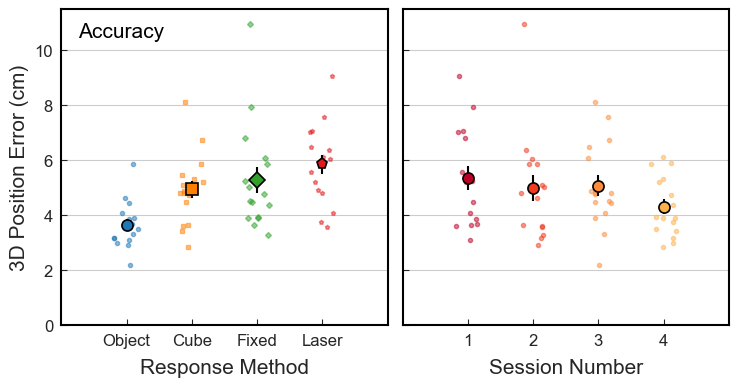

In [18]:
paper_figure_mode_session(trials, 
                          measure='tar_error_pos', 
                          ylabel='3D Position Error (cm)', 
                          yscale=100, 
                          ylim=(0, 11.5), 
                          agg_fun=np.mean,
                          corner_label='Accuracy')


### Precision (Variable Error)

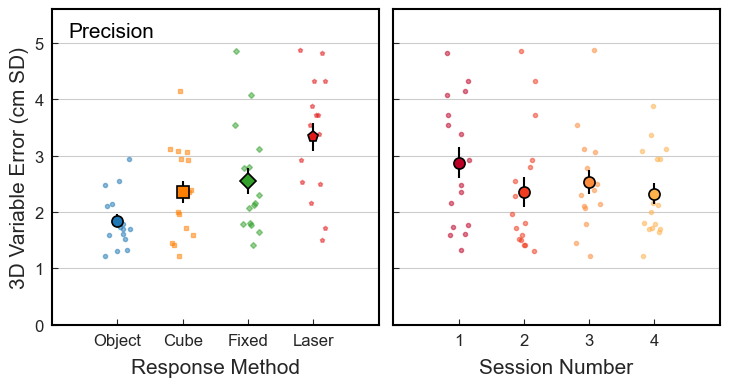

In [19]:
paper_figure_mode_session(trials, 
                          measure='tar_error_pos', 
                          ylabel='3D Variable Error (cm SD)', 
                          yscale=100, 
                          ylim=(0, 5.6), 
                          agg_fun=np.std,
                          corner_label='Precision')


### Response Duration

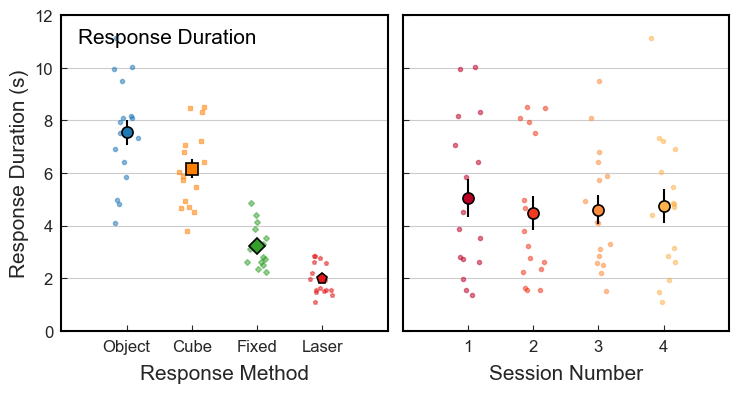

In [20]:
paper_figure_mode_session(trials, 
                          measure='response_duration', 
                          ylabel='Response Duration (s)',
                          ylim=(0, 12),
                          corner_label='Response Duration')


### Subjective Workload Score

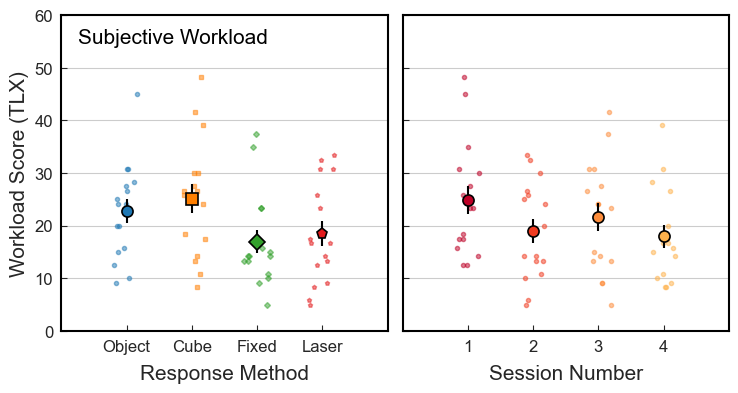

In [21]:
paper_figure_mode_session(tlx, 
                          measure='Global', 
                          ylabel='Workload Score (TLX)',
                          ylim=(0, 60),
                          corner_label='Subjective Workload')


## Paper Figures

Final figures for the manuscript. Make sure to run the Part2 notebook first to reproduce estimated marginal means data, if you want to fully reproduce all figures!


### 📊 Fig. 2: Objects in Scenes

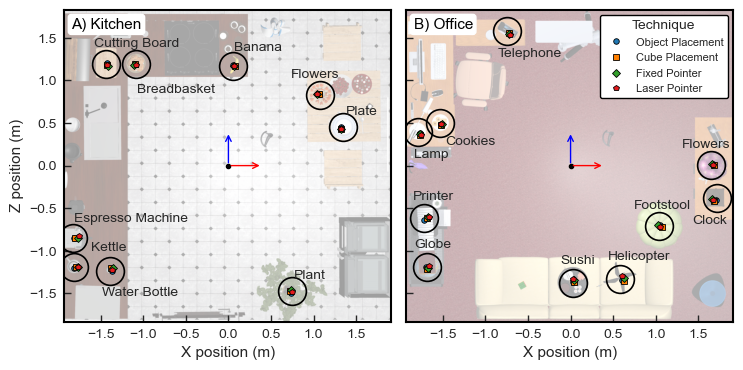

In [22]:
# Horizontal version
def plot_scenes_and_objects_horz(trials, scenes, figsize=(5,9), scene_alpha=1):
    
    LABEL_POS = {'Cutting Board': [-0.15, 0.05],
                 'Banana': [0, 0.03],
                 'Breadbasket': [0, -0.48],
                 'Flowers': [-0.35, 0.05],
                 'Clock': [-0.3, -0.45],
                 'Footstool': [-0.3, 0.05],
                 'Water Bottle': [-0.1, -0.45],
                 'Kettle': [0.19, 0.04],
                 'Espresso Machine': [0, 0.05],
                 'Lamp': [-0.05, -0.45],
                 'Helicopter': [-0.15, 0.07],
                 'Sushi': [-0.15, 0.07],
                 'Globe': [-0.15, 0.07],
                 'Printer': [-0.15, 0.07],
                 'Telephone': [-0.12, -0.45],
                 'Cookies': [0.05, -0.4]}
    
    LABEL_SIZE = 11
    TICK_SIZE = 10
    TICKPAD = 5
    ARROW_LENGTH = 0.4
    TARGET_COLOR = 'k'
    MARKERSIZE=4
    HEADINGS = {'K01': 'A) Kitchen', 'O02': 'B) Office'}
    COND_LABELS = ['Object Placement', 'Cube Placement', 'Fixed Pointer', 'Laser Pointer']

    fig, ax = plt.subplots(1, len(scenes), figsize=figsize, sharex='all', sharey='all')
    
    scn = {sc: Image.open(scenes[sc]) for sc in SCENES}
    legend_handles = []
    legend_labels = []
    
    for six, sc in enumerate(SCENES):
        ax[six].imshow(scn[sc], alpha=scene_alpha, origin='upper', extent=(-2.5, 2.5, -2.5, 2.5))
        ax[six].text(0.0225, 0.94, HEADINGS[sc], transform = ax[six].transAxes, horizontalalignment='left', color='k', fontsize=LABEL_SIZE,
                    bbox=dict(boxstyle="round", ec='w', facecolor='w', pad=0.2))
    
        df = trials.loc[trials.scene == sc, :].sort_values('target')
        for oix, o in enumerate(df.target.unique().tolist()):
            df_o = df.loc[df.target == o, :]
            
            # Object position
            ax[six].plot(np.nanmean(df_o.target_pos_x), np.nanmean(df_o.target_pos_z), 'o', ms=20, markeredgewidth=1.2, alpha=1, markerfacecolor='none', color=TARGET_COLOR, zorder=3)
            
            # Object label
            label = OBJECT_LABELS[df_o.target.values[0]]
            if label in LABEL_POS.keys():
                l_x = np.nanmean(df_o.target_pos_x) + 0.01 + LABEL_POS[label][0]
                l_z = np.nanmean(df_o.target_pos_z) + 0.15 + LABEL_POS[label][1]
            else:
                l_x = np.nanmean(df_o.target_pos_x) + 0.03
                l_z = np.nanmean(df_o.target_pos_z) + 0.15                
            ax[six].text(l_x, l_z, label, fontsize=TICK_SIZE)
            
            # Endpoints for each response method
            for cix, cond in enumerate(CONDS):
                h, = ax[six].plot(np.nanmean(df_o.loc[df_o.response_mode == cond, :].response_pos_x_pivot), 
                             np.nanmean(df_o.loc[df_o.response_mode == cond, :].response_pos_z_pivot), 
                             marker=COND_MARKERS[cix],
                             ms=MARKERSIZE, 
                             lw=0, 
                             alpha=1, 
                             markeredgewidth=0.6,
                             markeredgecolor='k',
                             color=COND_COLORS[cix], 
                             zorder=2) # avg response
                
                if six == 0 and oix == 0:
                    legend_labels.append(COND_LABELS[cix])
                    legend_handles.append(h)
            
            
    ax[0].set_xlabel('X position (m)', fontsize=LABEL_SIZE)
    ax[1].set_xlabel('X position (m)', fontsize=LABEL_SIZE)
    ax[0].set_ylabel('Z position (m)', fontsize=LABEL_SIZE)

    for axx in ax.flatten():

        axx.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
        axx.tick_params(axis='y', labelsize=TICK_SIZE, direction='in', size=5, width=1, pad=TICKPAD)
        axx.tick_params(axis='x', labelsize=TICK_SIZE, direction='in', size=5, width=1, pad=TICKPAD)
        axx.set_ylim([-1.83, 1.83])
        axx.set_xlim([-1.93, 1.91])
        axx.annotate("", xy=(ARROW_LENGTH, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color='r'))
        axx.annotate("", xy=(0, ARROW_LENGTH), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color='b'))
        axx.plot(0, 0, 'ko', ms=3)
        axx.grid(False)
        for axis in ['bottom','left', 'top','right']:
            axx.spines[axis].set_linewidth(1.5)
            axx.spines[axis].set_color('k')
    
    l = ax[1].legend(legend_handles, legend_labels, frameon=True, facecolor='w', edgecolor='k', framealpha=1, fontsize=8)
    l.set_title('Technique')
    
    plt.tight_layout()
    #fig.subplots_adjust(left=0.15, right=0.98, bottom=0.02, top=1.03, hspace=-0.15)

    
plot_scenes_and_objects_horz(trials, scene_imgs, scene_alpha=0.4, figsize=(7.6, 3.7))
plt.savefig(os.path.join(folder_fig, 'Fig2_ObjectsInScenes_horiz.png'), dpi=300)

### 📊 Fig. 3 - Accuracy, Precision, Response Duration

In [31]:
def annotate_comparison(ax, x1, x2, y, label, linewidth=1.0, fontsize=10, height=0.3, color='k'):
    """ Annotate a significant comparison """
    t = ax.text(x=(x1+x2)/2, y=y, s=label, fontsize=fontsize, ha='center')
    bb = t.get_window_extent(renderer=ax.get_figure().canvas.get_renderer()).transformed(ax.transData.inverted())
    txtheight = bb.height * 0.75
    ax.plot([x1, x1, x2, x2], 
            [y - height - txtheight, y - txtheight, y - txtheight, y-height - txtheight], 
            ls='-', 
            lw=linewidth, 
            color=color)
    
    
def paper_figure_acc_prec_rt(trials, dodge=0.4, ylabel='Forgot to set Y label', marker='o', ylim=None, emm_acc=None, emm_prec=None, emm_rt=None):
    
    FIGSIZE = (15, 5)
    PPID_ALPHA = 0.4
    LABEL_SIZE = 20
    TICK_SIZE = 13
    MARKER_SIZE = 9
    PPID_MARKER_SIZE = 4
    XPAD = 7
    TICKPAD = 6
    COND_LABELS = ['Object Pl.', 'Cube Pl.', 'Fixed P.', 'Laser P.']
    
    fig, ax = plt.subplots(1, 3, figsize=FIGSIZE)
    
    for cix, c in enumerate(CONDS):
        
        # Subplot 1: Accuracy
        df = trials.loc[trials.response_mode == c, ['ppid', 'tar_error_pos']].groupby('ppid').aggregate(np.nanmean)
        x = cix+1
        ax[0].plot(x + (np.random.random((df.shape[0], 1)) - 0.5) * dodge,
                     df.loc[:, 'tar_error_pos'] * 100, 
                     marker=COND_MARKERS[cix], markersize=PPID_MARKER_SIZE, lw=0,
                     color=COND_COLORS[cix], label=c, alpha=PPID_ALPHA)
        
        # Estimated marginal means
        if emm_acc is not None:
            ax[0].errorbar(x, emm_acc.loc[emm_acc.x == c, 'predicted'] * 100, yerr=emm_acc.loc[emm_acc.x == c, 'std.error'] * 100, color='k', 
                         label=c, alpha=1, marker=COND_MARKERS[cix], markerfacecolor=COND_COLORS[cix], 
                         markersize=MARKER_SIZE, markeredgewidth=1.5, markeredgecolor='k', elinewidth=1.8)

        ax[0].set_xlabel('Response Technique', fontsize=LABEL_SIZE, labelpad=XPAD)
        ax[0].set_xlim([0, len(CONDS)+1])
        ax[0].set_xticks(np.arange(1, len(CONDS)+1))
        ax[0].set_xticklabels(COND_LABELS, fontsize=TICK_SIZE)

        
        # Subplot 2: Precision
        df2 = trials.loc[trials.response_mode == c, ['ppid', 'tar_error_pos']].groupby('ppid').aggregate(np.nanstd)
        ax[1].plot(x + (np.random.random((df2.shape[0], 1)) - 0.5) * dodge,
                     df2.loc[:, 'tar_error_pos'] * 100, 
                     marker=COND_MARKERS[cix], markersize=PPID_MARKER_SIZE, lw=0,
                     color=COND_COLORS[cix], label=c, alpha=PPID_ALPHA)
        
        # Estimated marginal means
        if emm_prec is not None:
            ax[1].errorbar(x, emm_prec.loc[emm_prec.x == c, 'predicted'] * 100, yerr=emm_prec.loc[emm_prec.x == c, 'std.error'] * 100, color='k', 
                         label=c, alpha=1, marker=COND_MARKERS[cix], markerfacecolor=COND_COLORS[cix], 
                         markersize=MARKER_SIZE, markeredgewidth=1.5, markeredgecolor='k', elinewidth=1.8)
        
        ax[1].set_xlabel('Response Technique', fontsize=LABEL_SIZE, labelpad=XPAD)
        ax[1].set_xlim([0, len(CONDS)+1])
        ax[1].set_xticks(np.arange(1, len(CONDS)+1))
        ax[1].set_xticklabels(COND_LABELS, fontsize=TICK_SIZE)
        #print(s, round(m, 5), round(se, 3))
        
        # Subplot 3: Response Time
        df3 = trials.loc[trials.response_mode == c, ['ppid', 'response_duration']].groupby('ppid').aggregate(np.nanmean)
        ax[2].plot(x + (np.random.random((df2.shape[0], 1)) - 0.5) * dodge,
                   df3.loc[:, 'response_duration'], 
                   marker=COND_MARKERS[cix], markersize=PPID_MARKER_SIZE, lw=0,
                   color=COND_COLORS[cix], label=c, alpha=PPID_ALPHA)

        # Estimated marginal means
        if emm_rt is not None:
            ax[2].errorbar(x, emm_rt.loc[emm_rt.x == c, 'predicted'], yerr=emm_rt.loc[emm_rt.x == c, 'std.error'], color='k', 
                         label=c, alpha=1, marker=COND_MARKERS[cix], markerfacecolor=COND_COLORS[cix], 
                         markersize=MARKER_SIZE, markeredgewidth=1.5, markeredgecolor='k', elinewidth=1.8)
        
        ax[2].set_xlabel('Response Technique', fontsize=LABEL_SIZE, labelpad=XPAD)
        ax[2].set_xlim([0, len(CONDS)+1])
        ax[2].set_xticks(np.arange(1, len(CONDS)+1))
        ax[2].set_xticklabels(COND_LABELS, fontsize=TICK_SIZE)

        
    ax[0].set_ylabel('3D Position Error (cm)', fontsize=LABEL_SIZE)
    ax[1].set_ylabel('3D Position Error SD (cm)', fontsize=LABEL_SIZE)
    ax[2].set_ylabel('Response Duration (s)', fontsize=LABEL_SIZE)
    ax[0].text(0.05, 0.91, 'A) Accuracy', transform = ax[0].transAxes, horizontalalignment='left', color='k', fontsize=LABEL_SIZE)
    ax[1].text(0.05, 0.91, 'B) Precision', transform = ax[1].transAxes, horizontalalignment='left', color='k', fontsize=LABEL_SIZE)
    ax[2].text(0.05, 0.91, 'C) Response Duration', transform = ax[2].transAxes, horizontalalignment='left', color='k', fontsize=LABEL_SIZE)
    
    ax[0].set_ylim((0, 11.5))
    ax[1].set_ylim((0, 11.5))
    ax[2].set_ylim((0, 11.5))
    
    annotate_comparison(ax[0], 1, 2, 7.6, 'p=.004 **') # Accuracy - object - cube
    annotate_comparison(ax[0], 1, 3, 8.6, 'p=.026 *') # Accuracy - object - fixed
    annotate_comparison(ax[0], 1, 4, 9.6, 'p<.001 ***') # Accuracy - object - laser
    
    annotate_comparison(ax[1], 1, 4, 9, 'p<.001 ***') # Precision - object - laser
    annotate_comparison(ax[1], 1, 3, 8, 'p=.015 *') # Precision - object - fixed
    annotate_comparison(ax[1], 2, 4, 7, 'p=.001 **') # Precision - cube - laser
    annotate_comparison(ax[1], 3, 4, 6, 'p=.009 **') # Precision - cube - laser
    
    annotate_comparison(ax[2], 1, 4, 9.5, 'all p<.002 **') # All sig
    annotate_comparison(ax[2], 2, 3, 9.5, 'all p<.002 **') # All sig
    
    for axx in ax:
        axx.grid(axis='y', which='minor', color='gray')
        axx.grid(axis='x', visible=False)
        axx.tick_params(axis='both', labelsize=TICK_SIZE, direction='in', size=4, pad=TICKPAD)
        #axx.tick_params(axis='x', labelsize=TICK_SIZE, size=0, pad=TICKPAD)
        for axis in ['bottom','left','top','right']:
            axx.spines[axis].set_linewidth(1.5)
            axx.spines[axis].set_color('k')
        if ylim is not None:
            axx.set_ylim(ylim)
    
    plt.tight_layout()
    fig.subplots_adjust(left=0.11, right=1, bottom=0.18, top=0.95, wspace=0.23)
    

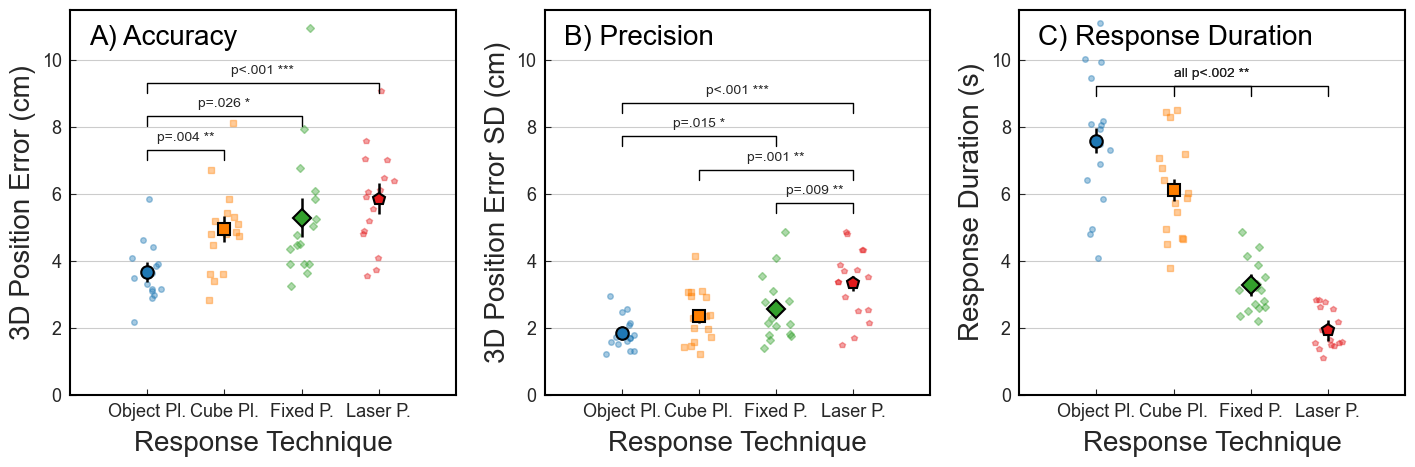

In [32]:
emm_acc = pd.read_csv(os.path.join(folder_results, 'emmeans_acc_response.csv'))
emm_prec = pd.read_csv(os.path.join(folder_results, 'emmeans_prec_response.csv'))
emm_rt = pd.read_csv(os.path.join(folder_results, 'emmeans_rt_response.csv'))

paper_figure_acc_prec_rt(trials, 
                     emm_acc=emm_acc,
                     emm_prec=emm_prec,
                     emm_rt=emm_rt)

plt.savefig(os.path.join(folder_fig, 'Fig3_AccuracyPrecisionRT.png'), dpi=300, bbox_inches='tight')

### 📊 Fig. 4 - Directional Accuracy

In [33]:
def paper_figure_acc_hist_all(trials, dodge=0.4, ylabel='Forgot to set Y label', marker='o', ylim=None, xlim=None, bins=20):
    
    FIGSIZE = (15, 9.20)
    PPID_ALPHA = 0.05
    LABEL_SIZE = 20
    TICK_SIZE = 16
    MARKER_SIZE = 9
    PPID_MARKER_SIZE = 4
    XPAD = 7
    TICKPAD = 6
    EDGE_LW = 1.4
    MEAN_LW = 1.8
    COND_LABELS = ['Object Placement', 'Cube Placement', 'Fixed Pointer', 'Laser Pointer']
    
    METRICS = ['ppid', 'tar_error_pos_x', 'tar_error_pos_y', 'tar_error_pos_z', 'tar_error_right_left', 'tar_error_away_toward']
    
    fig, ax = plt.subplots(2, 3, figsize=FIGSIZE)
    
    for cix, c in enumerate(CONDS):

        df = trials.loc[trials.response_mode == c, METRICS]
        x = cix + 1

        def add_hist(df, ax, var='tar_error_pos_x', color=COND_COLORS[0], label=COND_LABELS[0]):
            ax.hist(df.loc[:, var] * 100, 
                    density=False, 
                    bins=bins, 
                    edgecolor=color, 
                    facecolor=np.array(color + (PPID_ALPHA,)),
                    histtype='stepfilled',
                    lw=EDGE_LW, zorder=2)
            ax.axvline(np.nanmean(df.loc[:, var] * 100), color=color, ls=':', lw=MEAN_LW, zorder=1)
            ax.plot(np.nanmean(df.loc[:, var] * 100), 4, color=color, lw=0, marker=COND_MARKERS[cix], label=label, zorder=5, ms=8, alpha=0.8, markeredgecolor='k', markeredgewidth=1)

        
        # A) Scene X
        add_hist(df, ax[0, 0], var='tar_error_pos_x', color=COND_COLORS[cix], label=COND_LABELS[cix])
        ax[0, 0].set_xlabel('Endpoint Error, X (cm)', fontsize=LABEL_SIZE, labelpad=XPAD)
        
        # B) Scene Y
        add_hist(df, ax[0, 1], var='tar_error_pos_y', color=COND_COLORS[cix], label=COND_LABELS[cix])
        ax[0, 1].set_xlabel('Endpoint Error, Y (cm)', fontsize=LABEL_SIZE, labelpad=XPAD)

        # C) Scene Z
        add_hist(df, ax[0, 2], var='tar_error_pos_z', color=COND_COLORS[cix], label=COND_LABELS[cix])
        ax[0, 2].set_xlabel('Endpoint Error, Z (cm)', fontsize=LABEL_SIZE, labelpad=XPAD)

        # D) Ego left/right
        add_hist(df, ax[1, 0], var='tar_error_right_left', color=COND_COLORS[cix], label=COND_LABELS[cix])
        ax[1, 0].set_xlabel('Left/Right Error (cm)', fontsize=LABEL_SIZE, labelpad=XPAD)

        # E) Ego away/toward
        add_hist(df, ax[1, 1], var='tar_error_away_toward', color=COND_COLORS[cix], label=COND_LABELS[cix])
        ax[1, 1].set_xlabel('Near/Far Error (cm)', fontsize=LABEL_SIZE, labelpad=XPAD)
        
        # F) Scatter Plot
        df_gr = trials.loc[trials.response_mode == c, METRICS] #.groupby('ppid').aggregate(np.mean)
        ax[1, 2].plot(df_gr.tar_error_right_left * 100, df_gr.tar_error_away_toward * 100, marker=COND_MARKERS[cix], color=COND_COLORS[cix],  alpha=0.15, markeredgewidth=0, zorder=2, ms=3, lw=0)
        ax[1, 2].plot(np.nanmean(df_gr.tar_error_right_left) * 100, np.nanmean(df_gr.tar_error_away_toward) * 100, marker=COND_MARKERS[cix], color=COND_COLORS[cix], label=COND_LABELS[cix], zorder=4, ms=8, markeredgecolor='k', markeredgewidth=1, lw=0, alpha=0.8)
        confidence_ellipse(df.tar_error_right_left * 100, df.tar_error_away_toward * 100, ax[1, 2], n_std=2.0, facecolor='none', edgecolor=COND_COLORS[cix], linewidth=1.8, zorder=4)
        
        ax[1, 2].axvline(0, color='k', lw=1.2, zorder=1)
        ax[1, 2].axhline(0, color='k', lw=1.2, zorder=1)
        ax[1, 2].set_xlim(xlim)
        ax[1, 2].set_ylim(xlim)
        ax[1, 2].grid(axis='y', visible=True, which='major')
        ax[1, 2].grid(axis='x', visible=True, which='major')
        ax[1, 2].set_xticks([-15, -10, 0, 10, 15])
        ax[1, 2].set_yticks([-15, -10, 0, 10, 15])
        ax[1, 2].set_xlabel('Left/Right Error (cm)', fontsize=LABEL_SIZE, labelpad=XPAD)
        ax[1, 2].set_ylabel('Near/Far Error (cm)', fontsize=LABEL_SIZE, labelpad=XPAD)
 
        
    # Panel Text
    ax[0, 0].text(0.05, 0.91, 'A) Scene X', transform = ax[0, 0].transAxes, horizontalalignment='left', color='k', fontsize=LABEL_SIZE)
    ax[0, 1].text(0.05, 0.91, 'B) Scene Y', transform = ax[0, 1].transAxes, horizontalalignment='left', color='k', fontsize=LABEL_SIZE)
    ax[0, 2].text(0.05, 0.91, 'C) Scene Z', transform = ax[0, 2].transAxes, horizontalalignment='left', color='k', fontsize=LABEL_SIZE)
    ax[1, 0].text(0.05, 0.91, 'D) Participant Left/Right', transform = ax[1, 0].transAxes, horizontalalignment='left', color='k', fontsize=LABEL_SIZE)
    ax[1, 1].text(0.05, 0.91, 'E) Participant Near/Far', transform = ax[1, 1].transAxes, horizontalalignment='left', color='k', fontsize=LABEL_SIZE)
    ax[1, 2].text(0.05, 0.91, 'F) Participant Endpoint Error', transform = ax[1, 2].transAxes, horizontalalignment='left', color='k', fontsize=LABEL_SIZE)
    
    ax[0, 0].legend(title='Technique',frameon=True, facecolor='w', edgecolor='k', loc='upper left', bbox_to_anchor=(0.01, 0.88))
    ax[1, 2].legend(title='Technique',frameon=True, facecolor='w', edgecolor='k', loc='lower left')
    
    # Properties for all panels
    for axx in ax.flat:
        axx.tick_params(axis='both', labelsize=TICK_SIZE, direction='in', size=4, pad=TICKPAD)
        #axx.tick_params(axis='x', labelsize=TICK_SIZE, size=0, pad=TICKPAD)
        for axis in ['bottom','left','top','right']:
            axx.spines[axis].set_linewidth(1.5)
            axx.spines[axis].set_color('k')
        
        # Histograms only
        if axx != ax.flat[5]:
            axx.grid(axis='y', visible=False)
            axx.grid(axis='x', visible=False)
            if ylim is not None:
                axx.set_ylim(ylim)
            if xlim is not None:
                axx.set_xlim(xlim)
            axx.set_ylabel('Number of Trials', fontsize=LABEL_SIZE)

    
    plt.tight_layout()
    fig.align_ylabels()
    #fig.subplots_adjust(left=0.11, right=1, bottom=0.18, top=0.95, wspace=0.25, hspace=0.25)
    

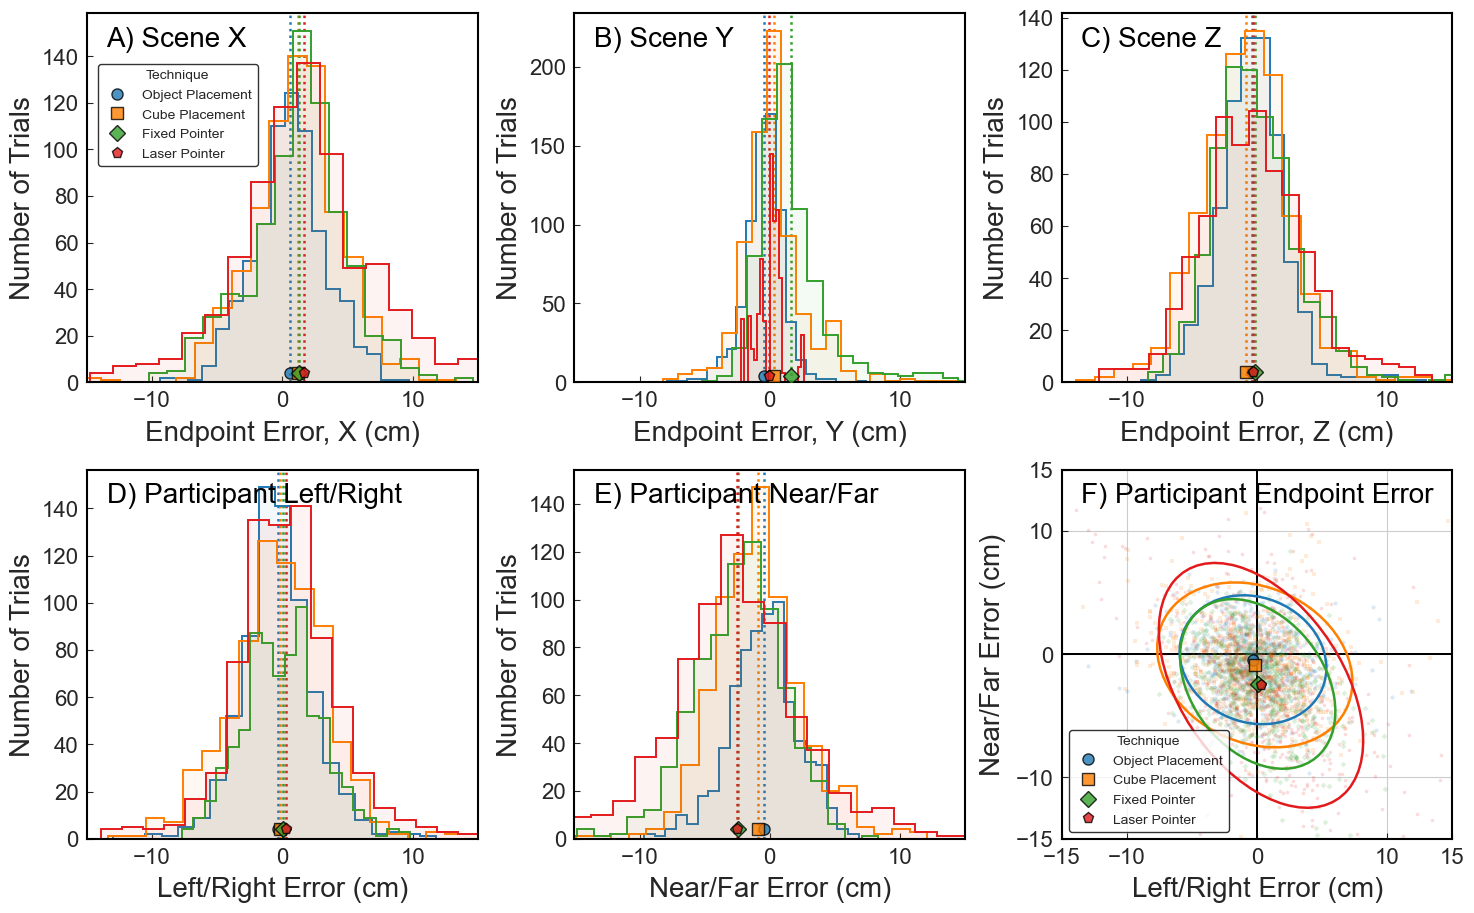

In [34]:
paper_figure_acc_hist_all(trials, xlim=(-15, 15), bins=20)
plt.savefig(os.path.join(folder_fig, 'Fig4_AccuracyHistogram.png'), dpi=300, bbox_inches='tight')

### 📊 Fig. 5 - Number of Interactions

In [35]:
def paper_figure_num_drops(trials, agg_fun=np.mean, dodge=0.3, marker='o', ylim=None, g_max=4, corner_label=''):
    
    drops = trials.loc[(trials.response_mode == 'cube') | (trials.response_mode == 'object'), :]

    FIGSIZE = (7.5, 4)
    PPID_ALPHA = 0.3
    LABEL_SIZE = 15
    TICK_SIZE = 12
    MARKER_SIZE = 7
    PPID_MARKER_SIZE = 3
    XPAD = 7
    TICKPAD = 6

    CONDS = ['object', 'cube']
    COND_LABELS = ['Object Placement', 'Cube Placement', 'Fixed Pointing', 'Laser Pointing']
    
    handles = []
    labels = []
    
    fig, ax = plt.subplots(1, 2, figsize=FIGSIZE)
    
    for cix, c in enumerate(CONDS):
        
        for grab in np.arange(1, g_max+1):
            df = drops.loc[(drops.response_mode == c) & (drops.drop_count == grab), :]
            #print(c, grab, df.shape[0], df.shape[0] / drops.loc[(drops.response_mode == c), :].shape[0])
            if df.shape[0] >= 10: 
            
                # Subplot 1: Response Duration
                x = grab - (0.5*dodge) + (dodge * cix)
                ax[0]
                h1 = ax[0].errorbar(x, 
                               np.nanmean(df.loc[:, 'response_duration']),
                               yerr=np.nanstd(df.loc[:, 'response_duration']) / np.sqrt(len(SUBS)), 
                               marker=COND_MARKERS[cix], 
                               ms=MARKER_SIZE, 
                               color='k', alpha=1, 
                               markerfacecolor=COND_COLORS[cix], 
                               markeredgecolor='k', 
                               markeredgewidth=1,
                               lw=1.5, zorder=3)

                # Subplot 2: Accuracy
                h2 = ax[1].errorbar(x, 
                               np.nanmean(df.loc[:, 'tar_error_pos'] * 100),
                               yerr=np.nanstd(df.loc[:, 'tar_error_pos'] * 100) / np.sqrt(len(SUBS)), 
                               marker=COND_MARKERS[cix], 
                               ms=MARKER_SIZE, 
                               color='k', alpha=1, 
                               markerfacecolor=COND_COLORS[cix], 
                               markeredgecolor='k', 
                               markeredgewidth=1,
                               lw=1.5, zorder=3)
        
            if grab == 1:
                handles.append(h1)
                labels.append(COND_LABELS[cix])
                
        # Plot across-subject averages from ealier Figure
        #pp_df = drops.loc[drops.response_mode == c, :].groupby('ppid').aggregate(agg_fun)
        #ax[0].axhline(np.nanmean(pp_df.loc[:, 'response_duration']),
        #              color=Set1_9.mpl_colors[cix],
        #              lw=1.5,
         #             ls='--', zorder=1)
        #ax[1].axhline(np.nanmean(pp_df.loc[:, 'tar_error_pos']) * 100,
        #              color=Set1_9.mpl_colors[cix],
         ##             lw=1.5,
         #             ls='--', zorder=1)

        
    ax[0].set_ylabel('Response Duration (s)', fontsize=LABEL_SIZE)
    ax[0].set_xlabel('Object Interaction Count', fontsize=LABEL_SIZE, labelpad=XPAD)
    ax[0].set_xticks(np.arange(1, 4+1))
    ax[0].set_xlim([0.5, 4.5])
    ax[0].set_ylim([0, 16])

    ax[1].set_ylabel('3D Position Error (cm)', fontsize=LABEL_SIZE)
    ax[1].set_xlabel('Object Interaction Count', fontsize=LABEL_SIZE, labelpad=XPAD)
    ax[1].set_xticks(np.arange(1, 4+1))
    ax[1].set_xlim([0.5, 4.5])
    ax[1].set_ylim([0, 11.5])
    
    ax[0].legend(handles, labels, loc='lower right', frameon=True, facecolor='w', edgecolor='k', framealpha=1,  title='Technique')
    ax[0].text(0.05, 0.91, 'A)', transform = ax[0].transAxes, horizontalalignment='left', color='k', fontsize=LABEL_SIZE)
    ax[1].text(0.05, 0.91, 'B)', transform = ax[1].transAxes, horizontalalignment='left', color='k', fontsize=LABEL_SIZE)
    
    for axx in ax:
        axx.grid(axis='y', which='minor', color='gray')
        axx.grid(axis='x', visible=False)
        axx.tick_params(axis='both', labelsize=TICK_SIZE, direction='in', size=4, pad=TICKPAD)
        for axis in ['bottom','left','top','right']:
            axx.spines[axis].set_linewidth(1.5)
            axx.spines[axis].set_color('k')
        if ylim is not None:
            axx.set_ylim(ylim)
    
    plt.tight_layout()
    fig.subplots_adjust(left=0.11, right=1, bottom=0.18, top=0.95)


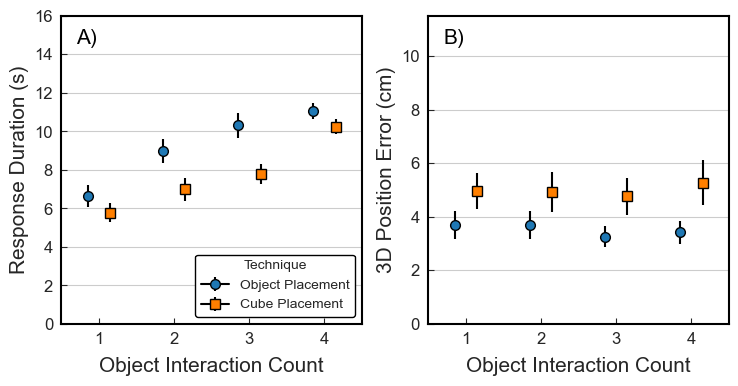

In [36]:
paper_figure_num_drops(trials)
plt.savefig(os.path.join(folder_fig, 'Fig5_NumInteractions.png'), dpi=300, bbox_inches='tight')

### 📊 Fig. 6 - Object Orientation

In [37]:
from scipy.spatial.transform import Rotation

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix



In [38]:
# Compute absolute angular error and per-axis error using rotation matrix
R_target = Rotation.from_euler('ZXY', trials.loc[:, ('target_euler_z', 'target_euler_x', 'target_euler_y')].values, degrees=True).apply([1, 0, 0])
R_response = Rotation.from_euler('ZXY', trials.loc[:, ('response_euler_z', 'response_euler_x', 'response_euler_y')].values, degrees=True).apply([1, 0, 0])

R_err = np.ones((R_target.shape[0], 1)) * np.nan # Absolute angular
R_rot = np.ones(R_target.shape) * np.nan # Axial error

for idx in np.arange(0, R_err.shape[0]):
    R_err[idx] = np.rad2deg(angle_between(R_target[idx, :], R_response[idx, :]))
    
    # Rotation using the scipy optimization algorithm
    #tmp = Rotation.align_vectors(R_response[idx, :].reshape((1, 3)), R_target[idx, :].reshape((1, 3)))[0].as_euler('ZXY', degrees=True)
    #R_rot[idx, :] = tmp
    
    tmpmat = rotation_matrix_from_vectors(R_response[idx, :].reshape((1, 3)), R_target[idx, :].reshape((1, 3)))
    tmp = Rotation.from_matrix(tmpmat).as_euler('ZXY', degrees=True)
    R_rot[idx, :] = tmp


In [39]:
# Summary statistics for cube and object placement only
rot_error = pd.DataFrame(R_rot, columns=('roll', 'pitch', 'yaw'))
rot_error.loc[:, 'roll'] = - rot_error.loc[:, 'roll'] # Roll is left-handed in Unity
rot_error.loc[:, 'response'] = trials.response_mode.values
rot_error = rot_error.loc[rot_error.response.isin(['object', 'cube'])]

print('Object')
display(rot_error.loc[rot_error.response == 'object', :].describe().T)

print('Cube')
display(rot_error.loc[rot_error.response == 'cube', :].describe().T)

Object


,count,mean,std,min,25%,50%,75%,max
roll,702.0,2.668359,43.031537,-167.576474,-1.509624,-0.045091,0.902488,170.271118
pitch,702.0,-0.812634,5.980790,-63.065118,-1.855392,-0.233411,0.893700,63.357885
yaw,702.0,5.065438,16.137381,-51.113185,-2.294496,1.526018,9.020734,115.388822


Cube


,count,mean,std,min,25%,50%,75%,max
roll,740.0,19.139645,52.366019,-175.803860,-2.222432,1.640496,18.521900,176.553300
pitch,740.0,-2.377237,20.491865,-83.752595,-6.139994,-1.510166,1.719962,84.803241
yaw,740.0,22.953433,96.747632,-176.783165,-23.120684,36.161577,97.435208,177.929717


C:\Users\Immo\AppData\Local\Temp\ipykernel_21288\1305881687.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(['{:d}°'.format(a) for a in [0, -45, -90, -135, 180, 135, 90, 45]])
C:\Users\Immo\AppData\Local\Temp\ipykernel_21288\1305881687.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['{:d}°'.format(a) for a in [0, -45, -90, -135, 180, 135, 90, 45]])
C:\Users\Immo\AppData\Local\Temp\ipykernel_21288\1305881687.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(['{:d}°'.format(a) for a in [0, 45, 90, 135, 180, -135, -90, -45]])


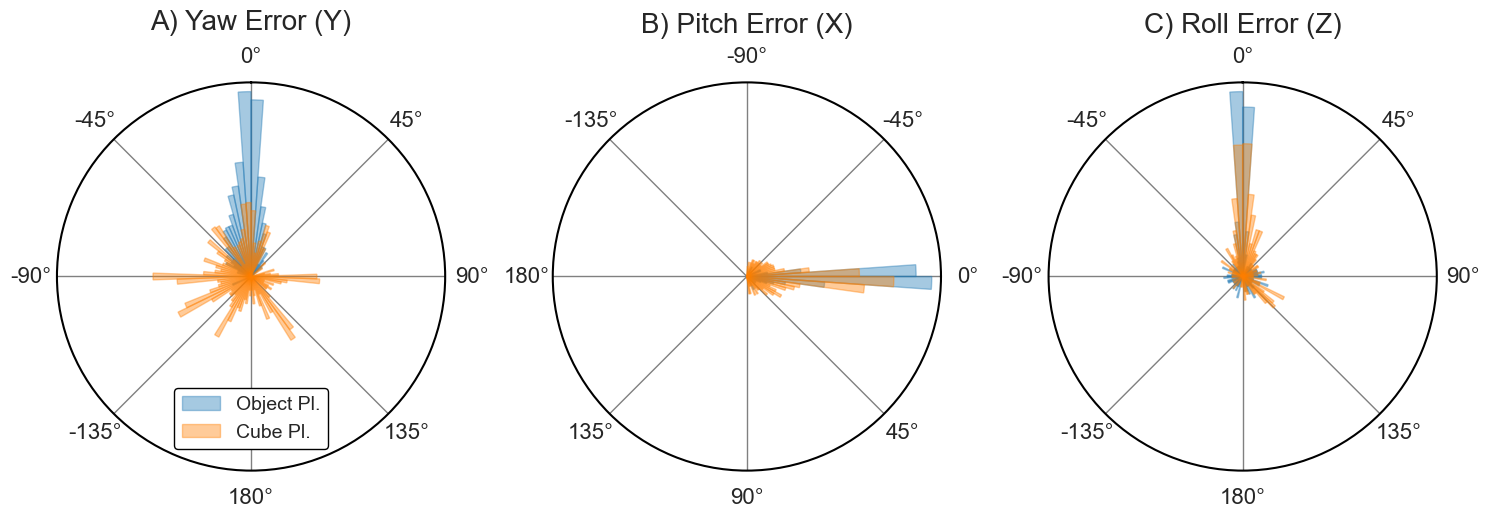

In [40]:
# Figure: Angular Error Histogram
BINS = 90 
RESPONSE_COLORS = {'object': Paired_12.mpl_colors[1],
                   'cube': Paired_12.mpl_colors[7]} # Use higher-contrast cube color
LABEL_SIZE = 20
TICK_SIZE = 16

def circular_density_hist(x, ax, bins=90, color=None, label=None):
    """ Add circular density histogram (area-based) to axis 
    see: https://stackoverflow.com/questions/22562364/circular-polar-histogram-in-python
    """
    
    x = (x+np.pi) % (2*np.pi) - np.pi
    bins = np.linspace(-np.pi, np.pi, num=bins+1)
    n, bins = np.histogram(x, bins=bins)
    widths = np.diff(bins)

    # Area to assign each bin
    area = n / x.size
    # Calculate corresponding bin radius
    radius = (area/np.pi) ** .5

    c = 'k'
    if color is not None:
        c = color
    patches = ax.bar(bins[:-1], radius, align='edge', width=widths,
                     edgecolor=c, color=c, fill=True, linewidth=1, alpha=0.4, label=label)


# Subplots: Y, X, Z - Unity order: Z, X, Y
fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection='polar'), figsize=(15, 5.5))
for splot, component in zip([0, 1, 2], [2, 1, 0]):    
    for response in ['object', 'cube']:
        o = circular_density_hist(ax=ax[splot], 
                                  x=np.deg2rad(R_rot[trials.response_mode == response, component]), 
                                  bins=BINS, 
                                  color=RESPONSE_COLORS[response], 
                                  label=response.capitalize() + " Pl.")
                                                    
# Set individual subplot parameters
ax[0].set_title('A) Yaw Error (Y)', fontsize=LABEL_SIZE, pad=12)
ax[0].set_theta_offset(np.deg2rad(90))
ax[0].set_xticklabels(['{:d}°'.format(a) for a in [0, -45, -90, -135, 180, 135, 90, 45]])

#ax[0].text(0.35, 0.92, 'left', transform=ax[0].transAxes, fontsize=TICK_SIZE)
#ax[0].text(0.55, 0.92, 'right', transform=ax[0].transAxes, fontsize=TICK_SIZE)

ax[1].set_title('B) Pitch Error (X)', fontsize=LABEL_SIZE, pad=10)
ax[1].set_xticklabels(['{:d}°'.format(a) for a in [0, -45, -90, -135, 180, 135, 90, 45]])
ax[2].set_title('C) Roll Error (Z)', fontsize=LABEL_SIZE, pad=10)
ax[2].set_theta_direction(-1) # Unity roll is inverted
ax[2].set_theta_offset(np.deg2rad(90))
ax[2].set_xticklabels(['{:d}°'.format(a) for a in [0, 45, 90, 135, 180, -135, -90, -45]])

ax[0].legend(loc='lower center', frameon=True, facecolor='w', edgecolor='k', fontsize=TICK_SIZE-2, framealpha=1, bbox_to_anchor=(0.5, 0.03, 0, 0))

# Global plot parameters
for axx in [0, 1, 2]:
    ax[axx].set_yticks([])
    ax[axx].tick_params(axis='both', labelsize=TICK_SIZE, direction='in', size=5, width=1, pad=12)
    ax[axx].grid(True, color='gray', lw=1)
    
    for axis in ['polar', 'start', 'end', 'inner']:
        ax[axx].spines[axis].set_linewidth(1.5)
        ax[axx].spines[axis].set_color('k')
    
plt.tight_layout()
plt.savefig(os.path.join(folder_fig, 'Fig6_AngleHistogram.png'), dpi=300, bbox_inches='tight')



### 📊 Fig. 7 - Subjective Workload

In [41]:
def paper_figure_tlx(trials, dodge=0.4, ylabel='Forgot to set Y label', yscale=1, marker='o', ylim=None, emm_resp=None, emm_sess=None):
    
    FIGSIZE = (7.5, 4.1)
    PPID_ALPHA = 0.4
    LABEL_SIZE = 15
    TICK_SIZE = 10
    MARKER_SIZE = 7
    PPID_MARKER_SIZE = 3
    XPAD = 7
    TICKPAD = 6
    COND_LABELS = ['Object Pl.', 'Cube Pl.', 'Fixed P.', 'Laser P.']
    
    measure = 'Global'
    GREYS = plt.get_cmap('Greys')(np.linspace(0.9, 0.3, 4))
    
    fig, ax = plt.subplots(1, 2, figsize=FIGSIZE, sharey='all')
    
    for cix, c in enumerate(CONDS):
        
        # Subplot 1: By Method
        df = trials.loc[trials.response_mode == c, ['ppid', measure]].groupby('ppid').aggregate(np.nanmean)

        x = cix+1
        ax[0].plot(x + (np.random.random((df.shape[0], 1)) - 0.5) * dodge,
                     df.loc[:, measure] * yscale, 
                     marker=COND_MARKERS[cix], markersize=PPID_MARKER_SIZE, lw=0,
                     color=COND_COLORS[cix], label=c, alpha=PPID_ALPHA)
        
        # Estimated marginal means
        if emm_resp is not None:
            ax[0].errorbar(x, emm_resp.loc[emm_resp.x == c, 'predicted'] * yscale, yerr=emm_resp.loc[emm_resp.x == c, 'std.error'] * yscale, color='k', 
                         label=c, alpha=1, marker=COND_MARKERS[cix], markerfacecolor=COND_COLORS[cix], 
                         markersize=MARKER_SIZE, markeredgewidth=1.2, markeredgecolor='k', elinewidth=1.5)

        ax[0].set_xlabel('Response Technique', fontsize=LABEL_SIZE, labelpad=XPAD)
        ax[0].set_xlim([0, len(CONDS)+1])
        ax[0].set_xticks(np.arange(1, len(CONDS)+1))
        ax[0].set_xticklabels(COND_LABELS, fontsize=TICK_SIZE)
        #print(c, round(m, 5), round(se, 3))

        
        # Subplot 2: Precision

    for cix, c in enumerate(SESS):
        x = cix+1
        df2 = trials.loc[trials.session_num == c, ['ppid', measure]].groupby('ppid').aggregate(np.nanmean)
        ax[1].plot(x + (np.random.random((df2.shape[0], 1)) - 0.5) * dodge,
                     df2.loc[:, measure] * yscale, 
                     marker='o', markersize=PPID_MARKER_SIZE, lw=0,
                     color=GREYS[cix], label=c, alpha=PPID_ALPHA)
        
        # Estimated marginal means
        if emm_sess is not None:
            ax[1].errorbar(x, emm_sess.loc[emm_sess.x == c, 'predicted'] * yscale, yerr=emm_sess.loc[emm_sess.x == c, 'std.error'] * yscale, color='k', 
                         label=c, alpha=1, marker=COND_MARKERS[0], markerfacecolor=GREYS[cix], 
                         markersize=MARKER_SIZE, markeredgewidth=1.2, markeredgecolor='k', elinewidth=1.5)
        
        ax[1].set_xlabel('Session', fontsize=LABEL_SIZE, labelpad=XPAD)
        ax[1].set_xlim([0, len(SESS)+1])
        ax[1].set_xticks(np.arange(1, len(SESS)+1))
        ax[1].set_xticklabels(SESS, fontsize=TICK_SIZE)
        
    ax[0].set_ylabel(ylabel, fontsize=LABEL_SIZE)
    ax[0].text(0.05, 0.91, 'A)', transform = ax[0].transAxes, horizontalalignment='left', color='k', fontsize=LABEL_SIZE)
    ax[1].text(0.05, 0.91, 'B)', transform = ax[1].transAxes, horizontalalignment='left', color='k', fontsize=LABEL_SIZE)
    
    annotate_comparison(ax[0], 1, 4, 51, 'p=.012 *', height=1.5) # object - laser
    annotate_comparison(ax[0], 1, 3, 46, 'p<.001 ***', height=1.5) # object - fixed
    annotate_comparison(ax[0], 2, 4, 41, 'p<.001 ***', height=1.5) # cube - laser
    annotate_comparison(ax[0], 2, 3, 36, 'p<.001 ***', height=1.5) # cube - fixed

    annotate_comparison(ax[1], 1, 4, 45, 'p<.001 ***', height=1.5) # 1 - 4
    annotate_comparison(ax[1], 1, 2, 40, 'p=.001 **', height=1.5) # 1 - 4

    for axx in ax:
        axx.grid(axis='y', which='minor', color='gray')
        axx.grid(axis='x', visible=False)
        axx.tick_params(axis='both', labelsize=TICK_SIZE, direction='in', size=4, pad=TICKPAD)
        #axx.tick_params(axis='x', labelsize=TICK_SIZE, size=0, pad=TICKPAD)
        for axis in ['bottom','left','top','right']:
            axx.spines[axis].set_linewidth(1.5)
            axx.spines[axis].set_color('k')
        if ylim is not None:
            axx.set_ylim(ylim)
    
    plt.tight_layout()
    fig.subplots_adjust(left=0.11, right=1, bottom=0.18, top=0.95)
    

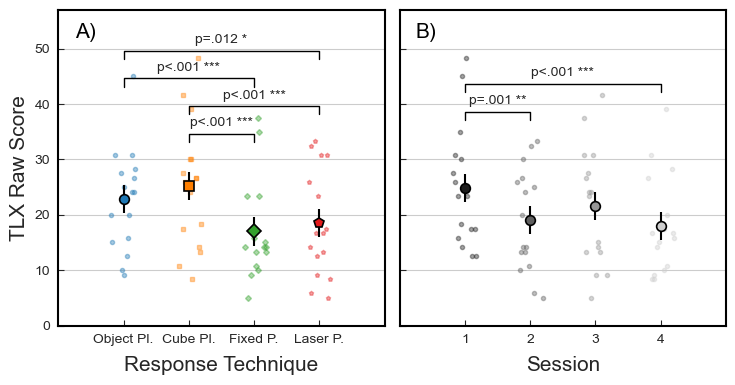

In [42]:
# LMM results (estimated marginal means)
emm_resp = pd.read_csv(os.path.join(folder_results, 'emmeans_tlx_response.csv'))
emm_sess = pd.read_csv(os.path.join(folder_results, 'emmeans_tlx_session.csv'))

paper_figure_tlx(tlx, emm_resp=emm_resp, emm_sess=emm_sess, ylim=(0, 57), ylabel='TLX Raw Score')
plt.savefig(os.path.join(folder_fig, 'Fig7_SubjectiveWorkload.png'), dpi=300, bbox_inches='tight')


## Statistics

### Endpoint Error - T-Tests against 0

In [43]:
from scipy.stats import ttest_1samp, ttest_rel, norm, shapiro, pearsonr
from statsmodels.stats.multitest import multipletests
from statsmodels.graphics.gofplots import qqplot

from itertools import combinations

In [44]:
# Endpoint error - Directional - One-sample t-tests
def significant_marker(x):
    out = ''
    if x < 0.05:
        out += '*'
    if x < 0.01:
        out += '*'
    if x < 0.001:
        out += '*'
    return out

# Run T-Tests for all axes (A-E in figure)
ttest0 = []
for axis in ['tar_error_pos_x', 'tar_error_pos_y', 'tar_error_pos_z', 'tar_error_right_left', 'tar_error_away_toward']:
    for cond in CONDS:
        
        values = trials.loc[trials.response_mode == cond, axis].values * 100.0 # in cm
        
        # shapiro-Wilk test for normality (p < .05 means non-normal)
        sw_res = shapiro(values)

        # T-test against zero
        tstat = ttest_1samp(values, popmean=0)
        
        d = {'axis': axis,
             'technique': cond,
             'N': values.shape[0],
             'mean_bias_cm': np.mean(values),
             'std': np.std(values),
             'shapiro_W': sw_res.statistic,
             'shapiro_p': sw_res.pvalue,
             'shapiro_sig': significant_marker(sw_res.pvalue),
             't': tstat.statistic,
             'p_raw': tstat.pvalue,
             'df': tstat.df
            }
        ttest0.append(d)

        # Q-Q Plot for diagnostics (uncomment to show)
        #fig, ax = plt.subplots(1, 1)
        #qqplot(values, ax=ax, line='s')
        #ax.set_title('{:s}, {:s}'.format(axis, cond))
        #plt.savefig(os.path.join(folder_fig, 'qqplot_{:s}_{:s}.png'.format(axis, cond)))

ttest0 = pd.DataFrame(ttest0)

# Correct for multiple testing
mt_result = multipletests(ttest0.p_raw.values, alpha=0.05, method='holm')
ttest0.loc[:, 'p_holm'] = mt_result[1]
ttest0.loc[:, 'sig_holm'] = ttest0.p_holm.apply(significant_marker)
mt_result = multipletests(ttest0.p_raw.values, alpha=0.05, method='bonferroni')
ttest0.loc[:, 'p_bonf'] = mt_result[1]
ttest0.loc[:, 'sig_bonf'] = ttest0.p_bonf.apply(significant_marker)

# Rename axis column for table
ttest0.loc[:, 'axis'] = ttest0.axis.map({'tar_error_pos_x': 'Scene X', 
                                         'tar_error_pos_y': 'Scene Y',
                                         'tar_error_pos_z': 'Scene Z',
                                         'tar_error_right_left': 'Egocentric LR', 
                                         'tar_error_away_toward': 'Egocentric FB'})

display(ttest0.round(3))
ttest0.round(3).to_csv('ttest_against_zero.csv', index=False, )

,axis,technique,N,mean_bias_cm,std,shapiro_W,shapiro_p,shapiro_sig,t,p_raw,df,p_holm,sig_holm,p_bonf,sig_bonf
0,Scene X,object,702,0.569,2.783,0.996,0.053,,5.413,0.000,701,0.000,***,0.000,***
1,Scene X,cube,740,1.182,3.422,0.986,0.000,***,9.391,0.000,739,0.000,***,0.000,***
2,Scene X,fixed,741,1.259,3.789,0.985,0.000,***,9.038,0.000,740,0.000,***,0.000,***
3,Scene X,laser,749,1.669,5.207,0.986,0.000,***,8.765,0.000,748,0.000,***,0.000,***
4,Scene Y,object,702,-0.420,1.524,0.963,0.000,***,-7.291,0.000,701,0.000,***,0.000,***
5,Scene Y,cube,740,0.292,2.460,0.933,0.000,***,3.222,0.001,739,0.011,*,0.027,*
6,Scene Y,fixed,741,1.658,2.820,0.841,0.000,***,15.997,0.000,740,0.000,***,0.000,***
7,Scene Y,laser,749,-0.033,1.009,0.935,0.000,***,-0.883,0.377,748,0.772,,1.000,
8,Scene Z,object,702,-0.369,2.620,0.967,0.000,***,-3.733,0.000,701,0.002,**,0.004,**
9,Scene Z,cube,740,-0.855,3.490,0.986,0.000,***,-6.662,0.000,739,0.000,***,0.000,***


### Endpoint Error - T-Test comparison

In [45]:
ttestC = []
for axis in ['tar_error_pos_x', 'tar_error_pos_y', 'tar_error_pos_z', 'tar_error_right_left', 'tar_error_away_toward']:
    
    for pair in combinations(CONDS, 2):
        
        a = trials.loc[trials.response_mode == pair[0], axis].values * 100.0 # in cm
        b = trials.loc[trials.response_mode == pair[1], axis].values * 100.0 # in cm
        
        # shapiro-Wilk tests for normality (p < .05 means non-normal)
        sw_res_a = shapiro(a)
        sw_res_b = shapiro(a)

        common_N = np.min([a.shape[0], b.shape[0]])
        
        # T-test against zero
        tstat = ttest_rel(a[0:common_N], b[0:common_N])
        
        d = {'axis': axis,
             'technique1': pair[0],
             'technique2': pair[1],

             'N1': values.shape[0],
             'mean1_cm': np.mean(a),
             'std1': np.std(a),
             'shapiro1_W': sw_res_a.statistic,
             'shapiro1_p': sw_res_a.pvalue,
             'shapiro1_sig': significant_marker(sw_res_a.pvalue),

             'N2': values.shape[0],
             'mean2_cm': np.mean(b),
             'std2': np.std(b),
             'shapiro2_W': sw_res_b.statistic,
             'shapiro2_p': sw_res_b.pvalue,
             'shapiro2_sig': significant_marker(sw_res_b.pvalue),
             
             'N_test': common_N,

             't': tstat.statistic,
             'p_raw': tstat.pvalue,
             'df': tstat.df
             
            }
        ttestC.append(d)

        # Q-Q Plot for diagnostics (uncomment to show)
        #fig, ax = plt.subplots(1, 1)
        #qqplot(values, ax=ax, line='s')
        #ax.set_title('{:s}, {:s}'.format(axis, cond))
        #plt.savefig(os.path.join(folder_fig, 'qqplot_{:s}_{:s}.png'.format(axis, cond)))

ttestC = pd.DataFrame(ttestC)

# Correct for multiple testing
mt_result = multipletests(ttestC.p_raw.values, alpha=0.05, method='holm')
ttestC.loc[:, 'p_holm'] = mt_result[1]
ttestC.loc[:, 'sig_holm'] = ttestC.p_holm.apply(significant_marker)
mt_result = multipletests(ttestC.p_raw.values, alpha=0.05, method='bonferroni')
ttestC.loc[:, 'p_bonf'] = mt_result[1]
ttestC.loc[:, 'sig_bonf'] = ttestC.p_bonf.apply(significant_marker)

# Rename axis column for table
ttestC.loc[:, 'axis'] = ttestC.axis.map({'tar_error_pos_x': 'Scene X', 
                                         'tar_error_pos_y': 'Scene Y',
                                         'tar_error_pos_z': 'Scene Z',
                                         'tar_error_right_left': 'Egocentric LR', 
                                         'tar_error_away_toward': 'Egocentric FB'})

display(ttestC.round(3))
ttestC.round(3).to_csv('ttest_comparison.csv', index=False, )

,axis,technique1,technique2,N1,mean1_cm,std1,shapiro1_W,shapiro1_p,shapiro1_sig,N2,...,shapiro2_p,shapiro2_sig,N_test,t,p_raw,df,p_holm,sig_holm,p_bonf,sig_bonf
0,Scene X,object,cube,749,0.569,2.783,0.996,0.053,,749,...,0.053,,702,-3.779,0.000,701,0.003,**,0.005,**
1,Scene X,object,fixed,749,0.569,2.783,0.996,0.053,,749,...,0.053,,702,-4.063,0.000,701,0.001,**,0.002,**
2,Scene X,object,laser,749,0.569,2.783,0.996,0.053,,749,...,0.053,,702,-4.961,0.000,701,0.000,***,0.000,***
3,Scene X,cube,fixed,749,1.182,3.422,0.986,0.000,***,749,...,0.000,***,740,-0.430,0.667,739,1.000,,1.000,
4,Scene X,cube,laser,749,1.182,3.422,0.986,0.000,***,749,...,0.000,***,740,-2.130,0.033,739,0.335,,1.000,
5,Scene X,fixed,laser,749,1.259,3.789,0.985,0.000,***,749,...,0.000,***,741,-1.746,0.081,740,0.732,,1.000,
6,Scene Y,object,cube,749,-0.420,1.524,0.963,0.000,***,749,...,0.000,***,702,-6.762,0.000,701,0.000,***,0.000,***
7,Scene Y,object,fixed,749,-0.420,1.524,0.963,0.000,***,749,...,0.000,***,702,-16.821,0.000,701,0.000,***,0.000,***
8,Scene Y,object,laser,749,-0.420,1.524,0.963,0.000,***,749,...,0.000,***,702,-5.845,0.000,701,0.000,***,0.000,***
9,Scene Y,cube,fixed,749,0.292,2.460,0.933,0.000,***,749,...,0.000,***,740,-10.196,0.000,739,0.000,***,0.000,***


### Session averaged metrics

In [46]:
# Per-session average metrics, error and response time
gl = trials.loc[:, ['response_mode', 'session_num', 'tar_error_pos', 'response_duration']] \
           .groupby(['response_mode', 'session_num']) \
           .agg(np.mean) \
           .reset_index()
gl.T


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
response_mode,cube,cube,cube,cube,fixed,fixed,fixed,fixed,laser,laser,laser,laser,object,object,object,object
session_num,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4
tar_error_pos,0.046807,0.048595,0.061515,0.041211,0.058213,0.060553,0.04984,0.040267,0.071438,0.051844,0.058051,0.052036,0.036749,0.035682,0.034764,0.039144
response_duration,6.62098,6.381082,5.867858,5.812004,3.240986,2.598299,3.249408,3.801709,1.917415,1.867906,2.28372,1.873945,8.431604,7.086217,6.913726,7.252209


In [47]:
# Per-session average metrics, TLX score
gltx = tlx.loc[:, ['response_mode', 'session_num', 'Global']] \
           .groupby(['response_mode', 'session_num']) \
           .agg(np.mean) \
           .reset_index()
gltx.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
response_mode,cube,cube,cube,cube,fixed,fixed,fixed,fixed,laser,laser,laser,laser,object,object,object,object
session_num,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4
Global,30.625,20.208333,30.0,19.791667,22.5,11.666667,20.833333,12.916667,21.041667,24.375,15.833333,12.708333,25.208333,19.791667,19.791667,26.458333
